# Dating S.bovis admixture

Neal Platt 2021

In [1]:
import os
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Image
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm

In [2]:
proj_dir = "/master/nplatt/sch_hae_scan"
results_dir = f"{proj_dir}/results"
os.chdir(results_dir)

In [3]:
Path(f"{results_dir}/dating_admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/dating_admixture")

In [4]:
pca_df = pd.read_csv(f"{proj_dir}/results/pca/pca_df.csv", sep=",")
pca_df = pca_df[["sample_name", "kmeans_label", "country"]]

In [5]:
adm_df = pd.read_csv(f"{proj_dir}/results/admixture/k2_adm_df.csv", sep=",")

In [6]:
adm_df = adm_df[["k2_sh", "k2_sb", "sample_name"]]

In [7]:
info_df = pca_df.merge(adm_df, on="sample_name")
info_df

,sample_name,kmeans_label,country,k2_sh,k2_sb
0,Sb_NG_au_1.2,sb,nigeria,0.000010,0.999990
1,Sb_NG_au_2.10,sb,nigeria,0.000010,0.999990
2,Sb_NG_au_2.13,sb,nigeria,0.000010,0.999990
3,Sb_NG_au_2.5,sb,nigeria,0.000010,0.999990
4,Sb_NG_au_2.6,sb,nigeria,0.000010,0.999990
...,...,...,...,...,...
157,ssp_niger_libore_166,sh_nw,niger,0.961084,0.038916
158,ssp_niger_libore_167,sh_nw,niger,0.959690,0.040310
159,ssp_niger_libore_168,sh_nw,niger,0.957791,0.042209
160,ssp_niger_libore_169,sh_nw,niger,0.957927,0.042073


In [14]:
(
    1
    - info_df.loc[
        ((info_df["country"] == "nigeria") & (info_df["kmeans_label"] == "sh_nw")),
        "k2_sh",
    ]
) * 100

9     26.2454
10    10.2684
11    15.5652
12     7.4459
13    10.9699
14     2.8110
51     1.1070
Name: k2_sh, dtype: float64

## Size distribution of Sb alleles in SH NW

In [84]:
# read in rfmix data
df = pd.read_csv("../rfmix/rfmix_df.csv")

In [85]:
df["n_bp"] = df["e_pos"] - df["s_pos"] + 1

In [86]:
df["n_bp"] = df["e_pos"] - df["s_pos"]

In [87]:
genome_size = df["n_bp"].sum()

In [88]:
def find_consecutive_regions_same_chrom(df, sample_id, target_allele):
    regions = []
    start_idx = None
    current_chrom = None
    length = 0
    start_pos = None
    end_pos = None

    for idx, row in df.iterrows():
        if row[sample_id] == target_allele and row["chrom"] == current_chrom:
            length += row["n_bp"]
            end_pos = row["e_pos"]
            if start_idx is None:
                start_idx = idx
                start_pos = row["s_pos"]
        else:
            if start_idx is not None:
                regions.append(
                    (current_chrom, start_idx, idx - 1, length, start_pos, end_pos)
                )
                start_idx = None
                length = 0
                start_pos = None
                end_pos = None
            if row[sample_id] == target_allele:
                start_idx = idx
                current_chrom = row["chrom"]
                length = row["n_bp"]
                start_pos = row["s_pos"]
            else:
                current_chrom = None
    if start_idx is not None:
        regions.append(
            (current_chrom, start_idx, len(df) - 1, length, start_pos, end_pos)
        )

    # Convert the list of tuples to a DataFrame
    regions_df = pd.DataFrame(
        regions, columns=["chrom", "start_idx", "end_idx", "length", "s_pos", "e_pos"]
    )
    return regions_df

In [89]:
nw_samples = list(pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name"].values)

In [92]:
samples = df.columns[6:-1]
sb_allele = 0

# make empty dataframe
column_names = ["sample", "pop", "sb_q", "med_l", "min_l", "max_l", "mean_l", "g"]
empty_df = pd.DataFrame(columns=column_names)


meds = []
mins = []
maxs = []
means = []
pops = []
qs = []
gs = []
used_samples = []
failed_samples = []
countries = []
chroms = []
starts = []
stops = []

for sample in tqdm(nw_samples):
    for hap in [0, 1]:
        hap_sample = f"{sample}.{hap}"
        try:
            pop = info_df.loc[info_df["sample_name"] == sample, "kmeans_label"].values[
                0
            ]
            # q   = info_df.loc[info_df["sample_name"] == sample, "k2_sh"].values[0]

            pops.append(pop)

            used_samples.append(hap_sample)

            regions_df = find_consecutive_regions_same_chrom(df, hap_sample, sb_allele)

            q = 1 - (regions_df["length"].sum() / genome_size)
            qs.append(q)

            meds.append(regions_df["length"].median())
            mins.append(regions_df["length"].min())
            maxs.append(regions_df["length"].max())
            means.append(regions_df["length"].mean())

            # get the longest region:
            longest_info = regions_df.loc[regions_df["length"].idxmax()]
            chroms.append(longest_info["chrom"])
            starts.append(longest_info["s_pos"])
            stops.append(longest_info["e_pos"])

            l = meds[-1]

            gs.append(1 / ((l * 3.3e-8) * q))
        except:
            failed_samples.append(hap_sample)

g_df = pd.DataFrame(
    columns=[
        "hap",
        "pop",
        "q",
        "med_l",
        "mean_l",
        "min_l",
        "max_l",
        "g",
        "longest_chrom",
        "longest_start",
        "longest_stop",
    ]
)

g_df["hap"] = used_samples
g_df["pop"] = pops
g_df["q"] = qs
g_df["med_l"] = meds
g_df["mean_l"] = means
g_df["min_l"] = mins
g_df["max_l"] = maxs
g_df["g"] = gs
g_df["longest_chrom"] = chroms
g_df["longest_start"] = starts
g_df["longest_stop"] = stops

g_df.to_csv("introgression_dates_per_indv.csv", sep=",", header=True, index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [03:58<00:00,  2.84s/it]


In [93]:
sample_ids = []
countries = []

for index, row in g_df.iterrows():
    hap_id = row["hap"]
    sample_id = ".".join(hap_id.split(".")[:-1])
    country = pca_df.loc[pca_df["sample_name"] == sample_id, "country"].values[0]

    sample_ids.append(sample_id)
    countries.append(country)


g_df["sample_id"] = sample_ids
g_df["country"] = countries

g_df.to_csv("introgression_dates_per_indv.csv", sep=",", header=True, index=False)
g_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,chrom,start,stop,sammple_id,country
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,NC_067200.1,2804,2469713.0,Sh_NG_eb_6_2,nigeria
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,NC_067200.1,2804,2494933.0,Sh_NG_eb_6_2,nigeria
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,NC_067200.1,213953,1884417.0,Sh_NG_ed_1_3,nigeria
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,NC_067200.1,214473,1966600.0,Sh_NG_ed_1_3,nigeria
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,NC_067200.1,2804,2343746.0,Sh_NG_ed_3_2,nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,NC_067196.1,124225,2142908.0,ssp_niger_libore_167,niger
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,NC_067200.1,162464,3008666.0,ssp_niger_libore_168,niger
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,NC_067200.1,207829,2925687.0,ssp_niger_libore_168,niger
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,NC_067200.1,2804,2469713.0,ssp_niger_libore_169,niger


In [8]:
g_df = pd.read_csv("introgression_dates_per_indv.csv", sep=",")
g_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,sammple_id,country
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,Sh_NG_eb_6_2,nigeria
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,Sh_NG_eb_6_2,nigeria
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,Sh_NG_ed_1_3,nigeria
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,Sh_NG_ed_1_3,nigeria
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,Sh_NG_ed_3_2,nigeria
...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,ssp_niger_libore_167,niger
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,ssp_niger_libore_168,niger
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,ssp_niger_libore_168,niger
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,ssp_niger_libore_169,niger


In [11]:
g_df["g"].median()

426.41632977423694

In [34]:
g_df = pd.read_csv("introgression_dates_per_indv.csv", sep=",", header=0)
g_df.loc[(g_df["country"] == "nigeria"), "med_l"].min()

45065.0

In [58]:
mean_g_nw = (
    g_df.loc[g_df["pop"] == "sh_nw"]
    .groupby(["country", "pop"])["g"]
    .agg(["median", "count"])
    .reset_index()
)
mean_g_nw.to_csv("nw_introgression_estimates_by_country.csv")
mean_g_nw

,country,pop,median,count
0,cameroon,sh_nw,333.213472,2
1,cote_d_ivoire,sh_nw,385.167152,42
2,egypt,sh_nw,286.855724,4
3,gambia,sh_nw,419.818458,2
4,guineabissau,sh_nw,363.347041,2
5,liberia,sh_nw,362.201741,4
6,mali,sh_nw,410.921152,2
7,niger,sh_nw,452.819454,74
8,nigeria,sh_nw,537.937081,14
9,senegal,sh_nw,424.473151,2


In [43]:
g_df.loc[g_df["country"] == "egypt"]

,hap,pop,q,med_l,mean_l,min_l,max_l,g,sammple_id,country
40,sh_egypt_SRR13579865.0,sh_nw,0.911715,113608.0,220369.649682,11616,2253918,292.562246,sh_egypt_SRR13579865,egypt
41,sh_egypt_SRR13579865.1,sh_nw,0.916333,87025.0,204926.656250,9576,2504854,380.004639,sh_egypt_SRR13579865,egypt
42,sh_egypt_SRR433862.0,sh_nw,0.945577,117680.0,219874.412371,14142,2059377,272.324433,sh_egypt_SRR433862,egypt
43,sh_egypt_SRR433862.1,sh_nw,0.945114,114042.0,253047.211765,6712,2059377,281.149202,sh_egypt_SRR433862,egypt


In [9]:
nw_df = g_df.loc[g_df["pop"] == "sh_nw"]

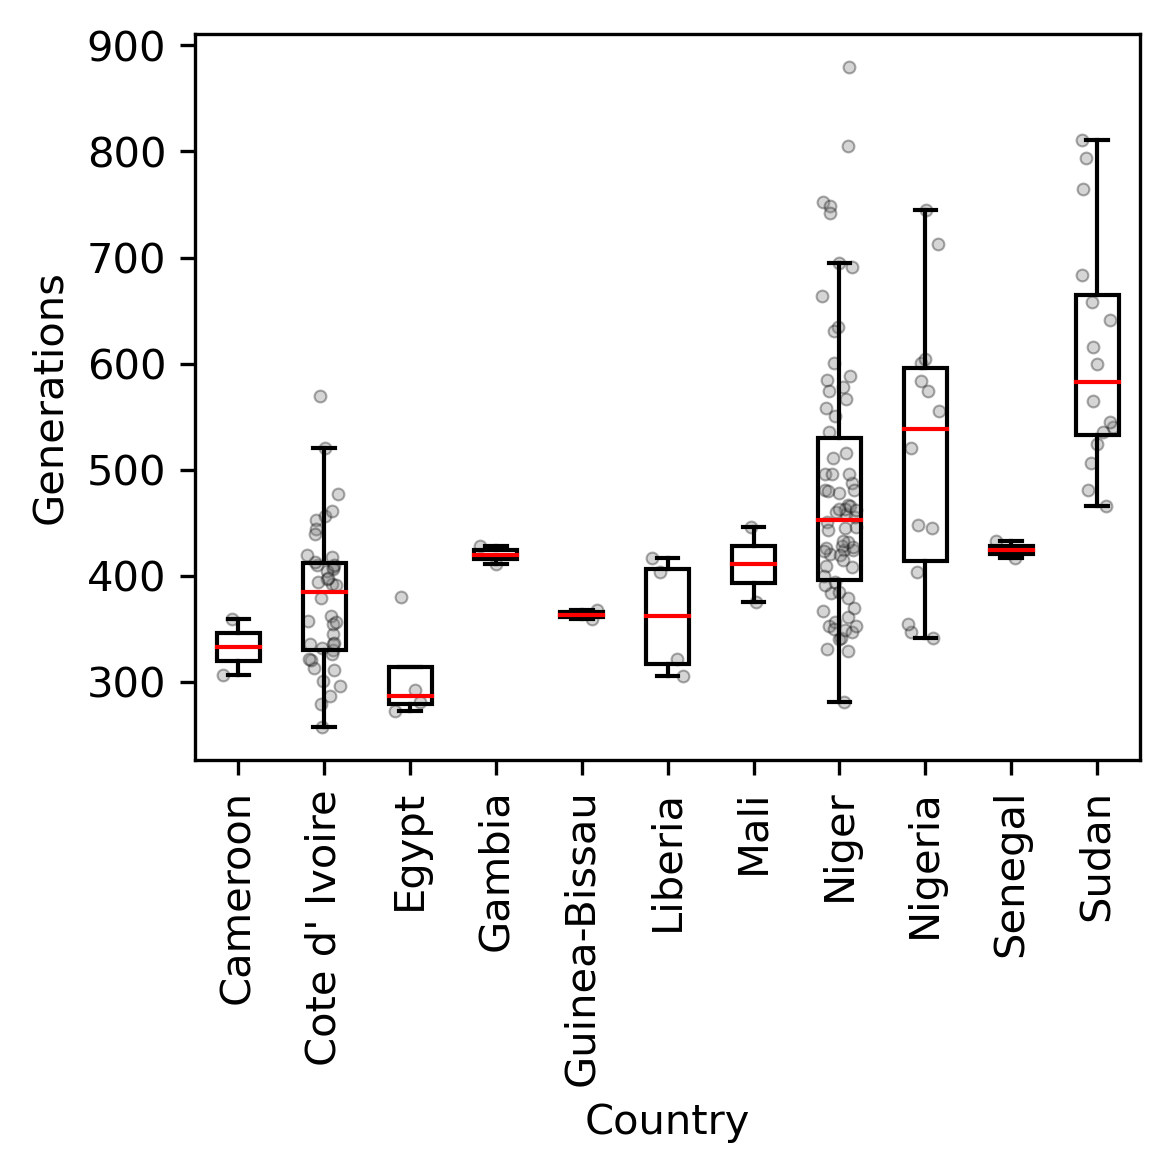

In [41]:
# Assuming nw_df is your DataFrame and it's already defined
# nw_df['country'] and nw_df['g'] columns exist

# Create a numeric column for country
nw_df["country_num"] = nw_df["country"].astype("category").cat.codes

# Define amount of jitter
jitter = 0.4

# Add jitter to 'country_num'
jittered_x = (
    nw_df["country_num"]
    + np.random.rand(len(nw_df["country_num"])) * jitter
    - jitter / 2
)

plt.figure(figsize=(4, 4), facecolor="white", dpi=300)

# Create scatter plot
plt.scatter(
    jittered_x,
    nw_df["g"],
    alpha=0.33,
    color="grey",
    edgecolor="black",
    linewidths=0.5,
    s=8,
)

# Add boxplot for each country
# Since boxplot positions are based on the unique values of 'country_num', we use those as positions.
for i in range(len(countries)):
    # Extract data for each country
    data = nw_df[nw_df["country_num"] == i]["g"]
    plt.boxplot(
        data,
        positions=[i],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor="none", color="black"),
        medianprops=dict(color="red"),
        showfliers=False,
    )

# Add country names to x-axis
countries = [
    "Cameroon",
    "Cote d' Ivoire",
    "Egypt",
    "Gambia",
    "Guinea-Bissau",
    "Liberia",
    "Mali",
    "Niger",
    "Nigeria",
    "Senegal",
    "Sudan",
]
plt.xticks(list(range(0, len(countries))), countries, rotation="vertical")

# Set labels
plt.xlabel("Country")
plt.ylabel("Generations")

plt.tight_layout()
plt.savefig("age_estimates_box.svg")
plt.show()

In [32]:
filtered_df = nw_df.groupby("country").filter(lambda x: len(x) > 2)
filtered_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,sammple_id,country,country_num
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,Sh_NG_eb_6_2,nigeria,8
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,Sh_NG_eb_6_2,nigeria,8
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,Sh_NG_ed_1_3,nigeria,8
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,Sh_NG_ed_1_3,nigeria,8
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,Sh_NG_ed_3_2,nigeria,8
...,...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,ssp_niger_libore_167,niger,7
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,ssp_niger_libore_168,niger,7
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,ssp_niger_libore_168,niger,7
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,ssp_niger_libore_169,niger,7


In [33]:
# ANOVA
model = ols("g ~ C(country)", data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

if anova_table["PR(>F)"][0] < 0.05:
    print("Significant differences found. Proceeding with Tukey's HSD...")
    # Tukey's HSD
    tukey = pairwise_tukeyhsd(
        endog=filtered_df["g"], groups=filtered_df["country"], alpha=0.05
    )
    print(tukey)
else:
    print("No significant differences found.")

                  sum_sq     df          F        PR(>F)
C(country)  8.309854e+05    5.0  14.521618  1.432592e-11
Residual    1.693831e+06  148.0        NaN           NaN
Significant differences found. Proceeding with Tukey's HSD...
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1     group2 meandiff p-adj    lower    upper   reject
---------------------------------------------------------------
cote_d_ivoire   egypt -72.4858 0.7875 -234.1217  89.1501  False
cote_d_ivoire liberia -17.3698 0.9996 -179.0057 144.2661  False
cote_d_ivoire   niger  99.7787    0.0   40.1024  159.455   True
cote_d_ivoire nigeria 137.8719 0.0007   42.5443 233.1995   True
cote_d_ivoire   sudan 229.1656    0.0  138.4164 319.9148   True
        egypt liberia   55.116 0.9781 -163.3071  273.539  False
        egypt   niger 172.2645 0.0247   13.6967 330.8323   True
        egypt nigeria 210.3577 0.0088   35.2297 385.4857   True
        egypt   sudan 301.6514    0.0  128.9728   474.33   True

In [61]:
nws = g_df.loc[g_df["pop"] == "sh_nw", "g"]
ses = g_df.loc[g_df["pop"] == "sh_se", "g"]
sbs = g_df.loc[g_df["pop"] == "sb", "g"]

In [63]:
g_df.loc[g_df["pop"] == "sh_nw", "med_l"].median()

76282.5

In [66]:
nws.median()

426.41632977423694

In [102]:
nws.min()

257.0622510236241

In [101]:
nws.max()

879.637421684046

In [67]:
np.percentile(nws, 2.5)

281.5800324849554

In [68]:
np.percentile(nws, 97.5)

763.9873160385066

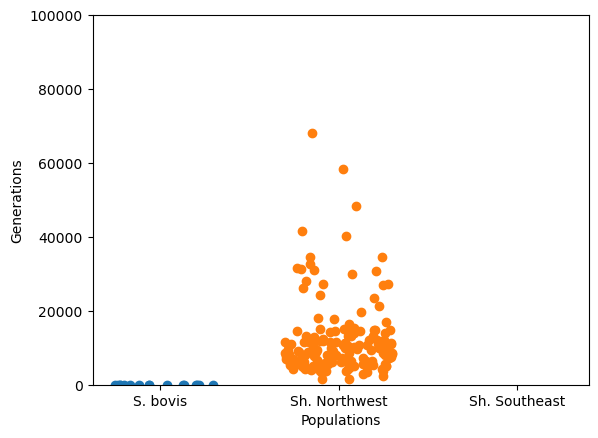

In [88]:
# # Jitter function
# def jitter(arr, jitter_factor):
#     return arr + np.random.uniform(-jitter_factor, jitter_factor, len(arr))

# # Jitter the y-values
# jitter_factor = 0.3
# nws_jittered = jitter(np.array(nws), jitter_factor)
# ses_jittered = jitter(np.array(ses), jitter_factor)
# sbs_jittered = jitter(np.array(sbs), jitter_factor)

# # Create a scatter plot
# plt.scatter(jitter([1] * len(sbs), jitter_factor), sbs)
# plt.scatter(jitter([2] * len(nws), jitter_factor), nws)
# plt.scatter(jitter([3] * len(ses), jitter_factor), ses)

# # Customize the plot
# plt.xticks([1, 2, 3], ['S. bovis', 'Sh. Northwest', 'Sh. Southeast'])
# plt.xlabel('Populations')
# plt.ylabel('Generations')
# plt.ylim([0,100000])
# #plt.yscale('log')
# #plt.legend('Median time since introgression')

# # Show the plot
# #plt.savefig("time_since_hybridization_scatter.svg")
# #plt.savefig("time_since_hybridization_scatter.png", dpi=300)
# plt.show()

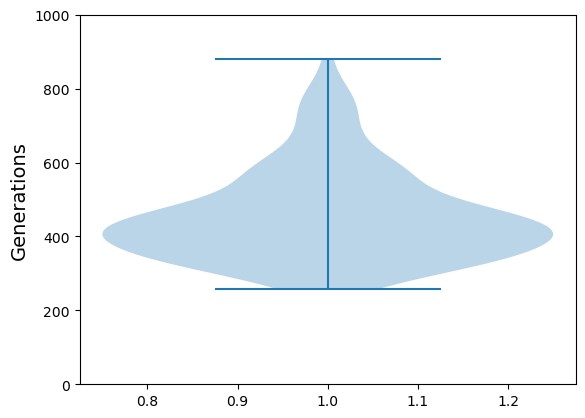

In [151]:
plt.violinplot(nws)
plt.ylabel("Generations", size=14)
plt.ylim([0, 1000])
plt.savefig("age_estimates.svg")

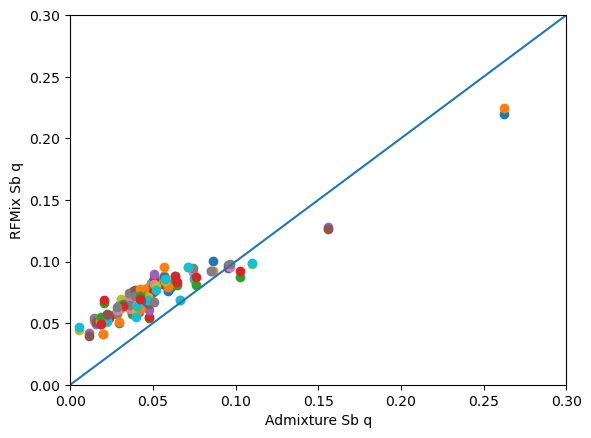

In [94]:
rf_qs = []
adm_qs = []

for index, row in g_df.iterrows():
    adm_sb_q = adm_df.loc[adm_df["sample_name"] == row["sammple_id"], "k2_sb"].values[0]
    rfmix_sb_q = 1 - row["q"]

    plt.scatter(adm_sb_q, rfmix_sb_q)

    rf_qs.append(rfmix_sb_q)
    adm_qs.append(adm_sb_q)

plt.xlabel("Admixture Sb q")
plt.ylabel("RFMix Sb q")
plt.plot([0, 1], [0, 1])
plt.xlim([0, 0.3])
plt.ylim([0, 0.3])
plt.savefig("rf_vs_adm_q.svg")
plt.savefig("rf_vs_adm_q.png", dpi=300)

plt.show()

In [98]:
(np.array(rf_qs) - np.array(adm_qs)).mean()

0.023834713988363385

In [82]:
1 - g_df["q"]

0      0.219388
1      0.224453
2      0.087528
3      0.092623
4      0.128092
         ...   
159    0.064085
160    0.076803
161    0.077629
162    0.072039
163    0.069691
Name: q, Length: 164, dtype: float64

In [126]:
sh_nw_samples = list(pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name"])

In [133]:
sb_allele = 0

gs = []
failed_samples = []

for sample in tqdm(nw_samples):
    for hap in [0, 1]:
        try:
            hap_sample = f"{sample}.{hap}"

            regions_df = find_consecutive_regions_same_chrom(df, hap_sample, sb_allele)

            l = np.array(regions_df["length"])
            q = 1 - regions_df["length"].sum() / genome_size

            gs.extend(1 / ((l * 3.3e-8) * q))
        except:
            failed_samples.append(sample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [03:50<00:00,  2.75s/it]


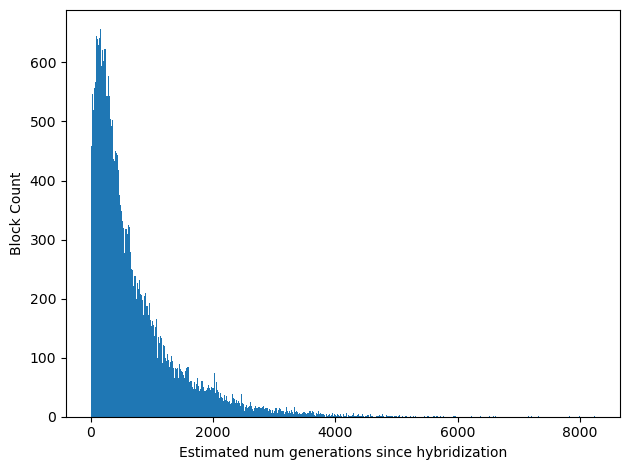

Median time since hybridization in the NW African metapopulation is: 464.9294868791543


In [138]:
plt.hist(gs, bins=500, linewidth=0.2)
plt.ylabel("Block Count")
plt.xlabel("Estimated num generations since hybridization")
plt.tight_layout()

plt.savefig("gens_since_hybridization_from_blocks.svg")
plt.savefig("gens_since_hybridization_from_blocks.png", dpi=300)
plt.show()

print(
    f"Median time since hybridization in the NW African metapopulation is: {np.median(gs)}"
)

(0.0, 400.0)

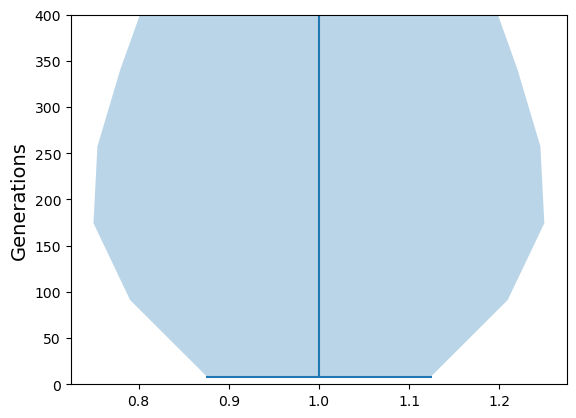

In [150]:
plt.violinplot(gs)
plt.ylabel("Generations", size=14)
plt.ylim([0, 400])
# plt.savefig("age_estimates.svg")

In [145]:
gs = np.array(gs)

gs.min()

8.026203688968883

In [146]:
gs.max()

8241.49367112194

In [147]:
np.percentile(gs, 2.5)

33.73379668510733

In [148]:
np.percentile(gs, 97.5)

2778.4259635569247

In [ ]:
samples = df.columns[6:-1]
sb_allele = 0

# make empty dataframe
column_names = ["sample", "pop", "sb_q", "med_l", "min_l", "max_l", "mean_l", "g"]
empty_df = pd.DataFrame(columns=column_names)


meds = []
mins = []
maxs = []
means = []
pops = []
qs = []
gs = []
used_samples = []
failed_samples = []
countries = []

for sample in tqdm(nw_samples):
    for hap in [0, 1]:
        hap_sample = f"{sample}.{hap}"
        try:
            pop = info_df.loc[info_df["sample_name"] == sample, "kmeans_label"].values[
                0
            ]
            # q   = info_df.loc[info_df["sample_name"] == sample, "k2_sh"].values[0]

            pops.append(pop)

            used_samples.append(hap_sample)

            regions_df = find_consecutive_regions_same_chrom(df, hap_sample, sb_allele)

            q = 1 - (regions_df["length"].sum() / genome_size)
            qs.append(q)

            meds.append(regions_df["length"].median())
            mins.append(regions_df["length"].min())
            maxs.append(regions_df["length"].max())
            means.append(regions_df["length"].mean())

            l = meds[-1]

            gs.append(1 / ((l * 3.3e-8) * q))
        except:
            failed_samples.append(hap_sample)

g_df = pd.DataFrame(
    columns=["hap", "pop", "q", "med_l", "mean_l", "min_l", "max_l", "g"]
)

g_df["hap"] = used_samples
g_df["pop"] = pops
g_df["q"] = qs
g_df["med_l"] = meds
g_df["mean_l"] = means
g_df["min_l"] = mins
g_df["max_l"] = maxs
g_df["g"] = gs

g_df.to_csv("introgression_dates_per_indv.csv", sep=",", header=True, index=False)

In [172]:
!pwd

/master/nplatt/sch_hae_scan/results/dating_admixture


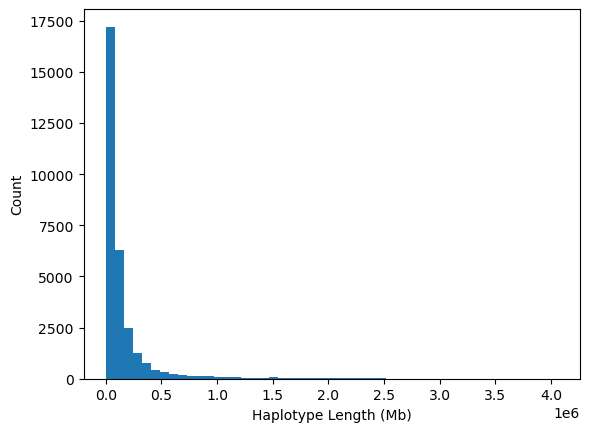

In [171]:
plt.hist(ls, bins=50)
plt.xlabel("Haplotype Length (Mb)")
plt.ylabel("Count")
plt.savefig("block_length_distribution.png", dpi=300)
plt.savefig("block_length_distribution.svg")
plt.show()

In [170]:
max(ls)

4053576

In [ ]:
indv_df = pd.read_csv("perc_bovis_per_indiv.csv", sep=",")

gs = []
# get dates from introgression tract lengths
for hap_id in hap_block_lengths.keys():
    l = np.mean(hap_block_lengths[hap_id])
    p = indv_df[indv_df["sample_id"] == hap_id]["perc_bovis"].values[0]

    # calc from schumer paper
    # recomb rate from Sm.
    g = 1 / ((l * 3.4e-8) * p)
    gs.append(g)

plt.hist(gs, bins=20, color="grey", edgecolor="black", linewidth=0.2)
plt.ylabel("Count".format(k))
plt.xlabel("Estimated num generations since hybridization")
plt.tight_layout()

plt.savefig("gens_since_hybridization_from_blocks.svg".format(k))
plt.savefig("gens_since_hybridization_from_blocks.png".format(k), dpi=300)
plt.show()

print(
    "Mean time since hybridization in the NW African metapopulation is: {}".format(
        np.mean(gs)
    )
)
print(
    "Min time since hybridization in the NW African metapopulation is: {}".format(
        np.min(gs)
    )
)

In [176]:
pca_df.loc[pca_df["country"] == "cameroon"]

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
44,sh_cameroon_SRR13579883,0.02949,-0.060985,0.01417,-0.053885,-0.015717,0.076234,-0.190402,0.019822,-0.013349,...,na,na,bovis,Rey_2019,genome,NaN,NaN,0,s_haematobium,sh_nw


In [183]:
tmp_df = find_consecutive_regions_same_chrom(df, "sh_cameroon_SRR13579883.0", sb_allele)
tmp_df["length"].sum()

17377336

In [181]:
tmp_df = find_consecutive_regions_same_chrom(df, "sh_cameroon_SRR13579883.1", sb_allele)
tmp_df["length"].sum()

18227284

In [190]:
sample = "sh_cameroon_SRR13579883.0"

In [195]:
# regions_df = find_consecutive_regions_same_chrom(df, sample, sb_allele)

l = regions_df["length"].median()
# q = info_df.loc[info_df["sample_name"] == sample[:-2], "k2_sb"].values[0]
q = 0.05

g = 1 / ((l * 3.3e-8) * q)
g

5865.916298653742

In [208]:
(1 / ((l * 3.3e-8) * 0.95))

308.73243677124964

In [205]:
1 / ((1033190 * 3.3e-8) * 0.99)

29.625839892190623

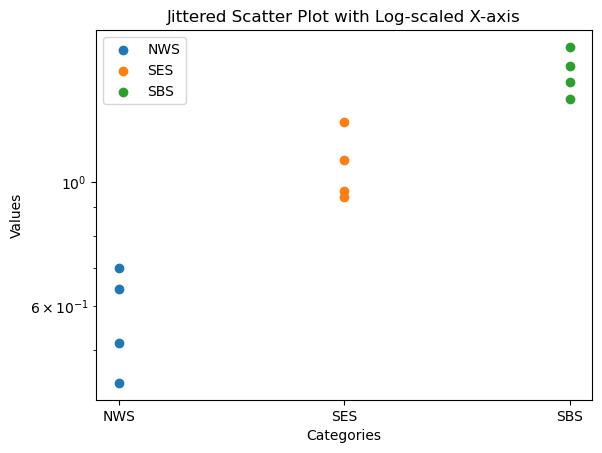

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists of floats
nws = [0.5, 0.6, 0.4, 0.7]
ses = [1.1, 1.0, 1.3, 0.9]
sbs = [1.6, 1.7, 1.4, 1.5]


# Jitter function
def jitter(arr, jitter_factor):
    return arr + np.random.uniform(-jitter_factor, jitter_factor, len(arr))


# Jitter the y-values
jitter_factor = 0.05
nws_jittered = jitter(np.array(nws), jitter_factor)
ses_jittered = jitter(np.array(ses), jitter_factor)
sbs_jittered = jitter(np.array(sbs), jitter_factor)

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter([1] * len(nws), nws_jittered, label="NWS")
ax.scatter([2] * len(ses), ses_jittered, label="SES")
ax.scatter([3] * len(sbs), sbs_jittered, label="SBS")

# Set the x-axis to a log scale
ax.set_yscale("log")

# Customize the plot
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["NWS", "SES", "SBS"])
ax.set_xlabel("Categories")
ax.set_ylabel("Values")
ax.legend()
ax.set_title("Jittered Scatter Plot with Log-scaled X-axis")

# Show the plot
plt.show()

In [156]:
g_df.loc[g_df["pop"] == "sb"]

,hap,pop,q,med_l,mean_l,min_l,max_l,g
0,Sb_NG_au_1.2.0,sb,0.999990,23827565.5,3.265846e+07,1776789.0,93282664.0,1.271776
1,Sb_NG_au_1.2.1,sb,0.999990,28739666.5,3.919548e+07,1929297.0,93282664.0,1.054408
2,Sb_NG_au_2.13.0,sb,0.999990,47069652.5,4.900451e+07,19478542.0,93282664.0,0.643798
3,Sb_NG_au_2.13.1,sb,0.999990,46771573.0,4.355841e+07,5223463.0,93282664.0,0.647901
4,Sb_NG_be_1.5.0,sb,0.999990,47069652.5,4.900451e+07,19478542.0,93282664.0,0.643798
5,Sb_NG_be_1.5.1,sb,0.999990,36406123.0,4.355812e+07,10352455.0,93282664.0,0.832369
6,Sb_NG_en_1.1.0,sb,0.999990,23287880.0,3.265407e+07,51664.0,93282664.0,1.301249
7,Sb_NG_en_1.1.1,sb,0.999990,29088038.5,3.265320e+07,5177846.0,78666936.0,1.041780
20,bovis_ethiopia_SRR13579874.0,sb,0.999990,19478542.0,2.058935e+07,28261.0,79773470.0,1.555729
21,bovis_ethiopia_SRR13579874.1,sb,0.999990,11787620.0,1.863415e+07,30107.0,79821901.0,2.570776


In [127]:
samples = df.columns[6:-1]
sb_allele = 0

# Create an empty DataFrame with the specified columns
column_names = ["sample", "pop", "sb_q", "med_l", "min_l", "max_l", "mean_l", "g"]
result_df = pd.DataFrame(columns=column_names)

# Iterate over the samples and populate the DataFrame
for sample in tqdm(samples):
    try:
        # Get population and sb_q values from info_df
        pop = info_df.loc[info_df["sample_name"] == sample[:-2], "kmeans_label"].values[
            0
        ]
        sb_q = info_df.loc[info_df["sample_name"] == sample[:-2], "k2_sb"].values[0]

        # Find consecutive regions with the specified allele
        regions_df = find_consecutive_regions_same_chrom(df, sample, sb_allele)

        # Calculate median, min, max, and mean lengths
        med_l = regions_df["length"].median()
        min_l = regions_df["length"].min()
        max_l = regions_df["length"].max()
        mean_l = regions_df["length"].mean()

        # Calculate g
        g = 1 / ((med_l * 3.3e-8) * sb_q)

        # Append the data to the result DataFrame
        result_df = result_df.append(
            {
                "sample": sample,
                "pop": pop,
                "sb_q": sb_q,
                "med_l": med_l,
                "min_l": min_l,
                "max_l": max_l,
                "mean_l": mean_l,
                "g": g,
            },
            ignore_index=True,
        )
    except:
        print(f"Failed to process sample {sample}")

# Display the result DataFrame
result_df

13.17241447613402

In [ ]:
1/

In [44]:
regions_df["length"].max()

2323729

In [46]:
regions_df["length"].max()

93282664

In [50]:
regions_df["length"].max()

156207

In [56]:
# get kmeans labels

# read in a small loter csv file
chrom = "NW_023366696.1"
tmp_df = pd.read_csv("csv_files/loter_{}.csv".format(chrom), sep=",", index_col=0)
hap_ids = tmp_df.index

# read in the pca df to get the kmeans labels (this will be used to subset the loter file into "populations")
pca_df = pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")

# store the kmeans labels for each HAPLOTYPE into a hap_labels dictionary
hap_labels = {}
for hap_id in hap_ids:
    sample = "_".join(hap_id.split("_")[:-1])
    k_label = pca_df.loc[pca_df["sample_name"] == sample]["kmeans_label"].values[0]
    hap_labels["{}_h1".format(sample)] = k_label
    hap_labels["{}_h2".format(sample)] = k_label

# now match the label with the sample in the wg df
k_labels = []
for hap_id in tmp_df.index:
    k_labels.append(hap_labels[hap_id])

# get idxs in the df for each population
k_idxs = {}
for k_label in set(k_labels):
    # np.where returns tuple.  get rid of it
    k_idxs[k_label] = np.where(np.array(k_labels) == k_label)[0]

In [523]:
genotype_label = {0: "Sh", 1: "Sb"}

# get hap block lengths per hap_id
hap_block_lengths = defaultdict(lambda: list())
csv_outs = []

for chrom in tqdm(uniq_chroms):

    # read in loter file
    #     chrom_loter_df=pd.read_csv("csv_files/loter_{}.csv".format(chrom), sep=",", index_col=0)
    chrom_loter_df = loter_chrom_dfs[chrom]
    chrom_loter_df.index.name = "sample_id"

    # ignore chrom if less than 1Mb
    chrom_len = int(chrom_loter_df.columns[-1].split(":")[-1])
    if chrom_len > 1000000:

        # convert to 2d numpy array
        chrom_loter_numpy = chrom_loter_df.to_numpy()

        # subset on the NW S. haem
        nw_chrom_loter_numpy = np.array(chrom_loter_df.iloc[k_idxs["Sh (NW)"],])

        for i in range(0, len(nw_chrom_loter_numpy)):
            start = 0
            hap_id = hap_ids[k_idxs["Sh (NW)"]][i]

            hap_blocks = [
                (k, sum(1 for i in g))
                for k, g in groupby(list(nw_chrom_loter_numpy[i]))
            ]

            for genotype, length in hap_blocks:
                chrom, start_pos = chrom_loter_df.columns[start].split(":")
                stop_pos = chrom_loter_df.columns[start + length - 1].split(":")[-1]

                # get info for a csv outfile
                csv_out = "{},{},{},{},{}\n".format(
                    hap_id, chrom, start_pos, stop_pos, genotype_label[genotype]
                )
                csv_outs.append(csv_out)

                hap_block_length = int(stop_pos) - int(start_pos) + 1
                if hap_block_length < 0:
                    print("error; {} {}", chrom, hap_id)
                    break
                if genotype_label[genotype] == "Sb":
                    hap_block_lengths[hap_id].append(hap_block_length)

                start += length

# save block info as a csv for downstream processing
with open("sb_hap_blocks_chr_gt_1mb.csv", "w") as out_f:
    for entry in csv_outs:
        out_f.write(entry)

# save as a pickle
hap_block_lengths = dict(hap_block_lengths)
with open("sb_hap_block_lengths_chr_gt_1mb.pickle", "wb") as handle:
    pickle.dump(hap_block_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #read in pickle if needed
# with open('hap_block_lengths.pickle', 'rb') as handle:
#     test = pickle.load(handle)

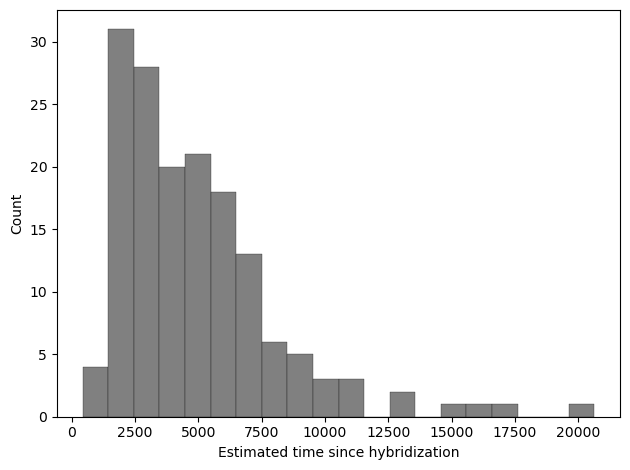

Mean time since hybridization in the NW African metapopulation is: 4918.665045086211
Min time since hybridization in the NW African metapopulation is: 421.5595272730728


In [522]:
indv_df = pd.read_csv("perc_bovis_per_indiv.csv", sep=",")

gs = []
# get dates from introgression tract lengths
for hap_id in hap_block_lengths.keys():
    l = np.mean(hap_block_lengths[hap_id])
    p = indv_df[indv_df["sample_id"] == hap_id]["perc_bovis"].values[0]

    # calc from schumer paper
    # recomb rate from Sm.
    g = 1 / ((l * 3.4e-8) * p)
    gs.append(g)

plt.hist(gs, bins=20, color="grey", edgecolor="black", linewidth=0.2)
plt.ylabel("Count".format(k))
plt.xlabel("Estimated num generations since hybridization")
plt.tight_layout()

plt.savefig("gens_since_hybridization_from_blocks.svg".format(k))
plt.savefig("gens_since_hybridization_from_blocks.png".format(k), dpi=300)
plt.show()

print(
    "Mean time since hybridization in the NW African metapopulation is: {}".format(
        np.mean(gs)
    )
)
print(
    "Min time since hybridization in the NW African metapopulation is: {}".format(
        np.min(gs)
    )
)

In [ ]:
# import seaborn as sns

# sns.distplot(flights['arr_delay'], hist=True, kde=True,
#              bins=int(180/5), color = 'darkblue',
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

# #see https://seaborn.pydata.org/tutorial/distributions.html

In [524]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [217]:
from scipy import stats

In [218]:
logx = np.log10(ls)

In [219]:
stats.skew(logx)

0.4427852353830916

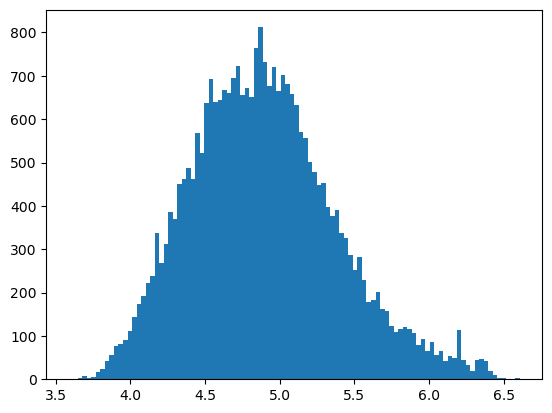

In [220]:
# plt.hist(x, 100)
counts, bins, bars = plt.hist(logx, 100)

plt.show()

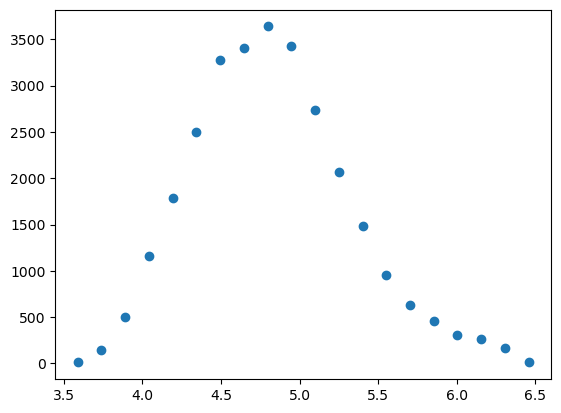

In [221]:
counts, bins, bars = plt.hist(logx, 20)
plt.clf()
plt.scatter(bins[:-1], counts)
plt.show()

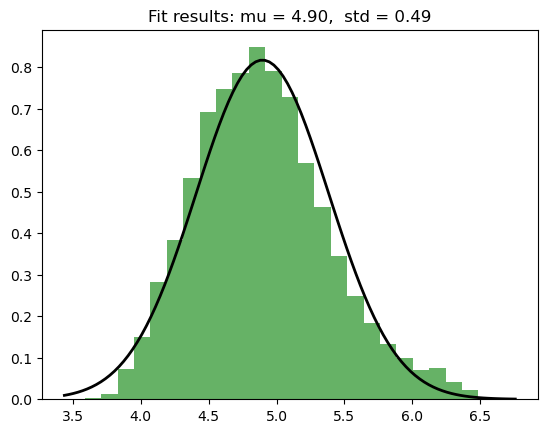

In [222]:
from scipy.stats import norm

mu, std = norm.fit(logx)
plt.hist(logx, bins=25, density=True, alpha=0.6, color="g")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)


p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

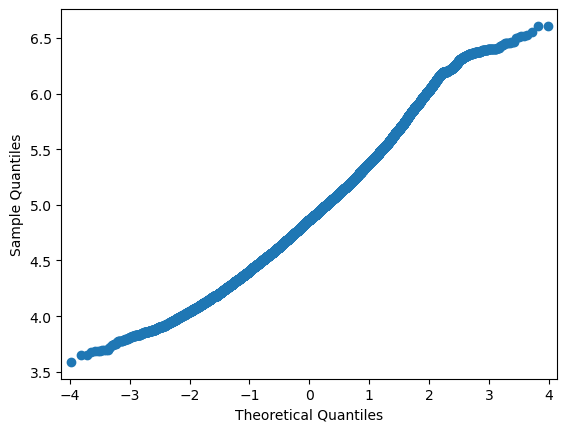

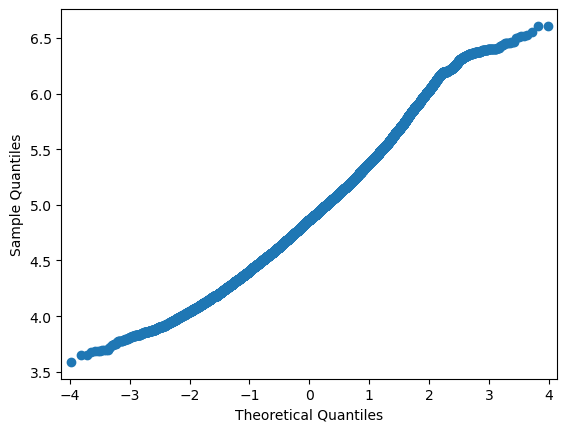

In [228]:
from statsmodels.graphics.gofplots import qqplot

qqplot(logx)

In [ ]:
from scipy.stats import shapiro

# normality test

nw_samples = list(pca_df[pca_df["kmeans_label"] == "Sh (NW)"]["sample_name"])
failed = 0
accept = 0
for sample_id in nw_samples:

    hap_1 = "_".join([sample_id, "h1"])
    hap_2 = "_".join([sample_id, "h2"])

    blocks = np.append(hap_block_lengths[hap_1], hap_block_lengths[hap_2])
    log_blocks = np.log10(blocks)

    stat, p = shapiro(log_blocks)
    # print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        # print('Sample {} looks Gaussian (fail to reject H0)'.format(hap_id))
        accept += 1
    else:
        failed += 1
        count, bins, bars = plt.hist(log_blocks)
        plt.title(sample_id)
        plt.show()
        # plt.clf()

In [646]:
accept / (failed + accept)

0.3924050632911392

In [641]:
len(np.append(hap_block_lengths[hap_1], hap_block_lengths[hap_2]))

211

In [643]:
len(hap_block_lengths[hap_2])

76

In [229]:
from scipy.stats import normaltest

stat, p = normaltest(logx)
print("Statistics=%.3f, p=%.3f" % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

Statistics=872.328, p=0.000
Sample does not look Gaussian (reject H0)


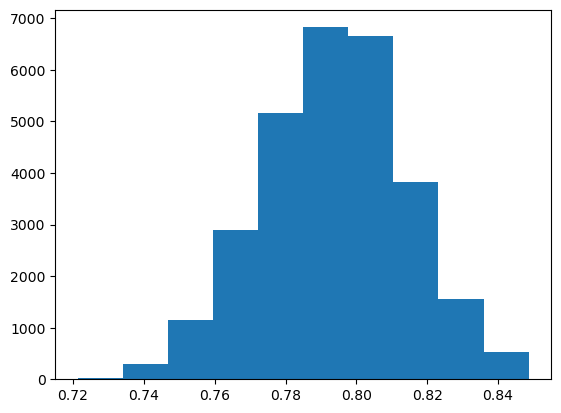

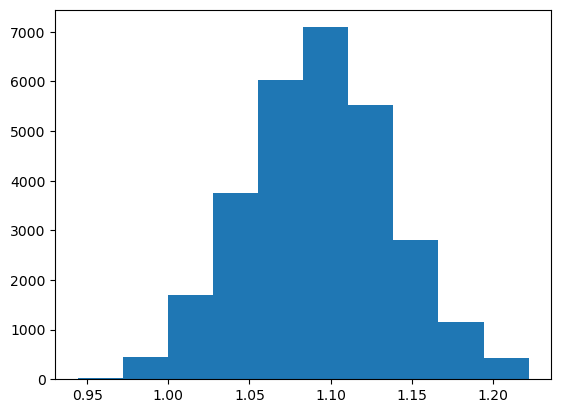

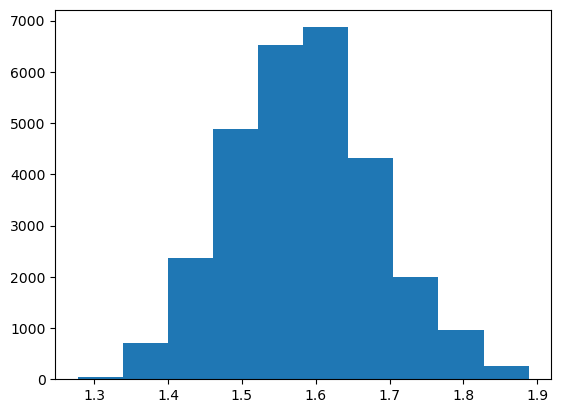

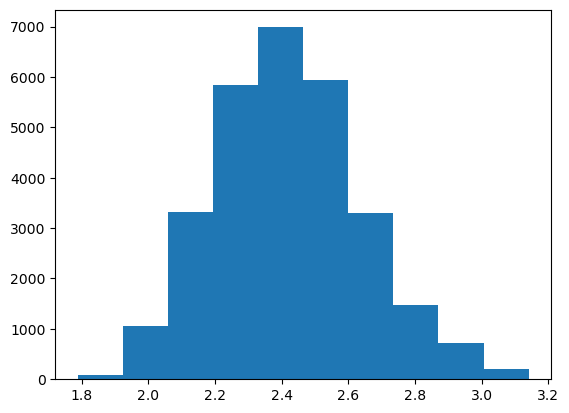

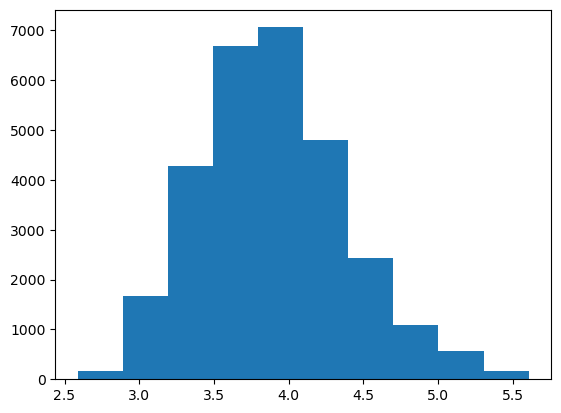

In [231]:
from scipy.stats import boxcox

for i in [-1, -0.5, 0, 0.5, 1]:
    data = boxcox(logx, i)
    plt.hist(data)
    plt.show()

In [233]:
from numpy.random import randn, seed
from scipy.stats import anderson

# normality test
result = anderson(logx)
print("Statistic: %.3f" % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print("%.3f: %.3f, data looks normal (fail to reject H0)" % (sl, cv))
    else:
        print("%.3f: %.3f, data does not look normal (reject H0)" % (sl, cv))

Statistic: 73.224
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [27]:
# Ancestry at invadolysin
# NW_023366679.1:8567548-8600607
pos = np.array([x.split(":")[1] for x in df.columns[1:]]).astype(int)

In [41]:
# (pos >= 8567548) & (pos <= 8600607)

mask = np.logical_and(pos > 8_567_548, pos < 8_600_607)
target_df = df.loc[:, df.columns[1:][mask]]

In [71]:
nw = df.iloc[k_idxs["Sh (NW)"],].sum(axis=0)
se = df.iloc[k_idxs["Sh (SE)"],].sum(axis=0)
sb = df.iloc[k_idxs["Sb"],].sum(axis=0)

In [92]:
nw_ac = nw.values[1:].astype(int)
se_ac = se.values[1:].astype(int)

In [112]:
xs = np.array([x.split(":")[1] for x in df.columns[1:]]).astype(int)

In [96]:
nw_af = nw_ac / len(k_idxs["Sh (NW)"])
se_af = se_ac / len(k_idxs["Sh (SE)"])

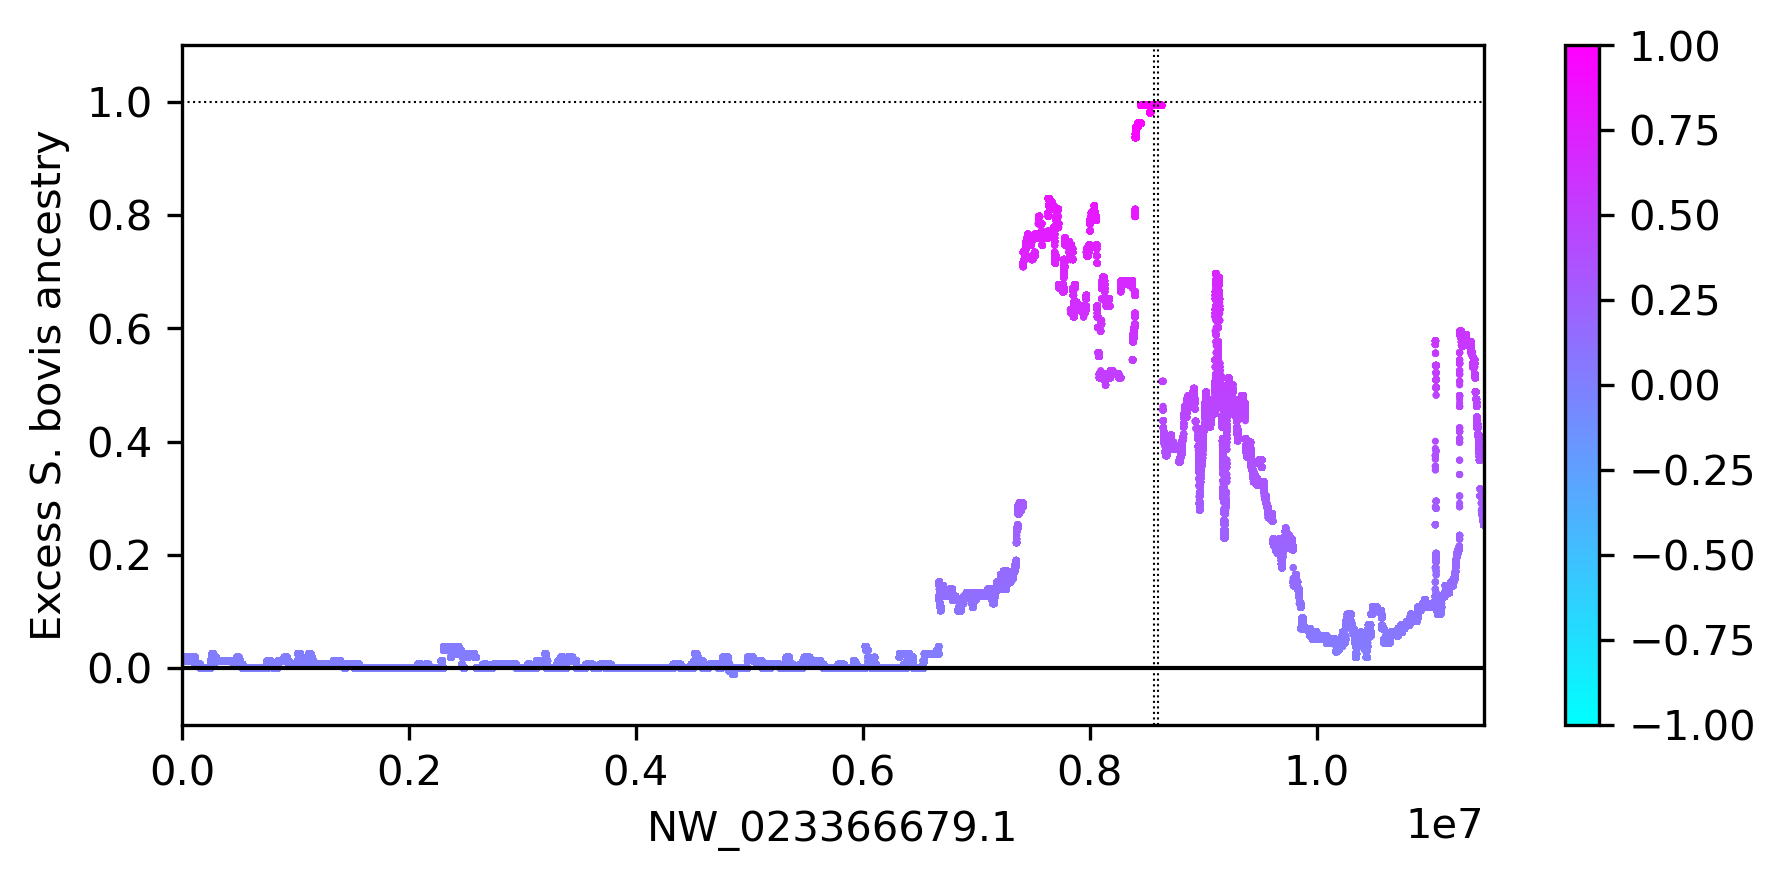

In [118]:
ys = nw_af - se_af
# xs=range(0,len(ys))

figure(figsize=(7, 3), dpi=300)
plt.scatter(xs, ys, c=ys, cmap="cool", s=0.5, vmin=-1, vmax=1)
plt.colorbar()
plt.ylim(-0.1, 1.1)
plt.xlim([0, xs[-1]])
plt.axhline(1, lw=0.5, linestyle=":", c="black")
# plt.axhline(-0.95, lw=1, linestyle=":", c="black")
plt.axvline(8_567_548, lw=0.5, linestyle=":", c="black")
plt.axvline(8_600_607, lw=0.5, linestyle=":", c="black")

plt.axhline(0, lw=1, c="black")
plt.xlabel("NW_023366679.1")
plt.ylabel("Excess S. bovis ancestry")
# plt.xticks([8_567_548, 8_567_548])
# plt.tick_params(labelbottom=False, length=7)

plt.show()
plt.close()